In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
random.seed(69)

In [2]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device = try_gpu()

In [3]:
device

device(type='cuda', index=0)

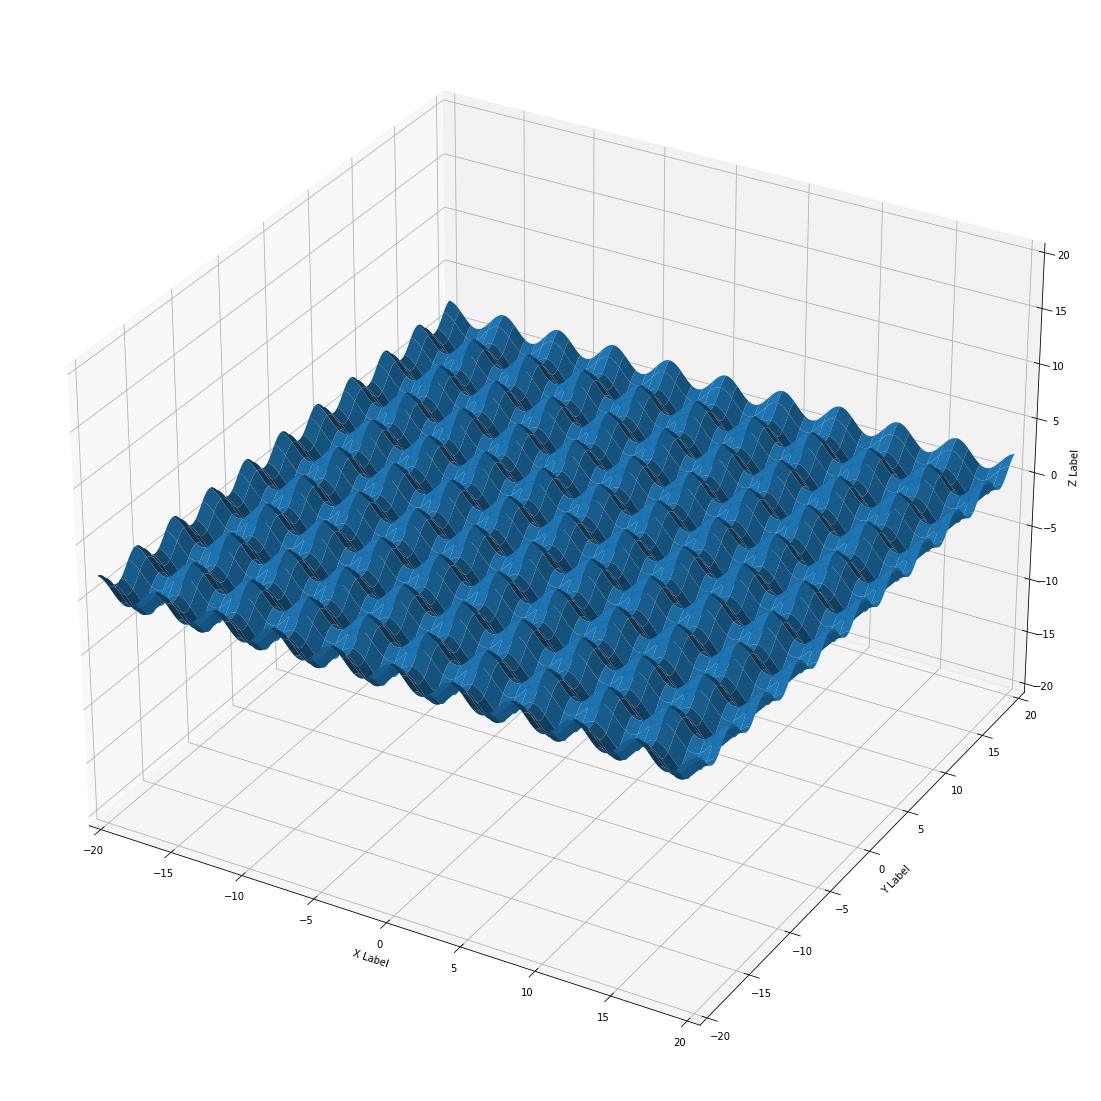

In [4]:
a = 0.5
rang = 20

def fun(x, y):
    return math.cos(a*math.pi*x) +  math.cos(a*math.pi*y)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-rang, rang, 0.1)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_zlim3d(-rang, rang)
ax.set_ylim3d(-rang, rang)
ax.set_xlim3d(-rang, rang)
plt.show()

In [5]:
inps = np.array([[x,y] for x,y in zip(np.ravel(X), np.ravel(Y))])

creating synthetic data

In [6]:
square = 13
x_train = []
y_train = []
x_test = []
y_test = []
for e in inps:
  if abs(e[0]) < square and abs(e[1]) < square:
    x_train.append(e)
    y_train.append(fun(e[0],e[1]))
  else:
    x_test.append(e)
    y_test.append(fun(e[0],e[1]))

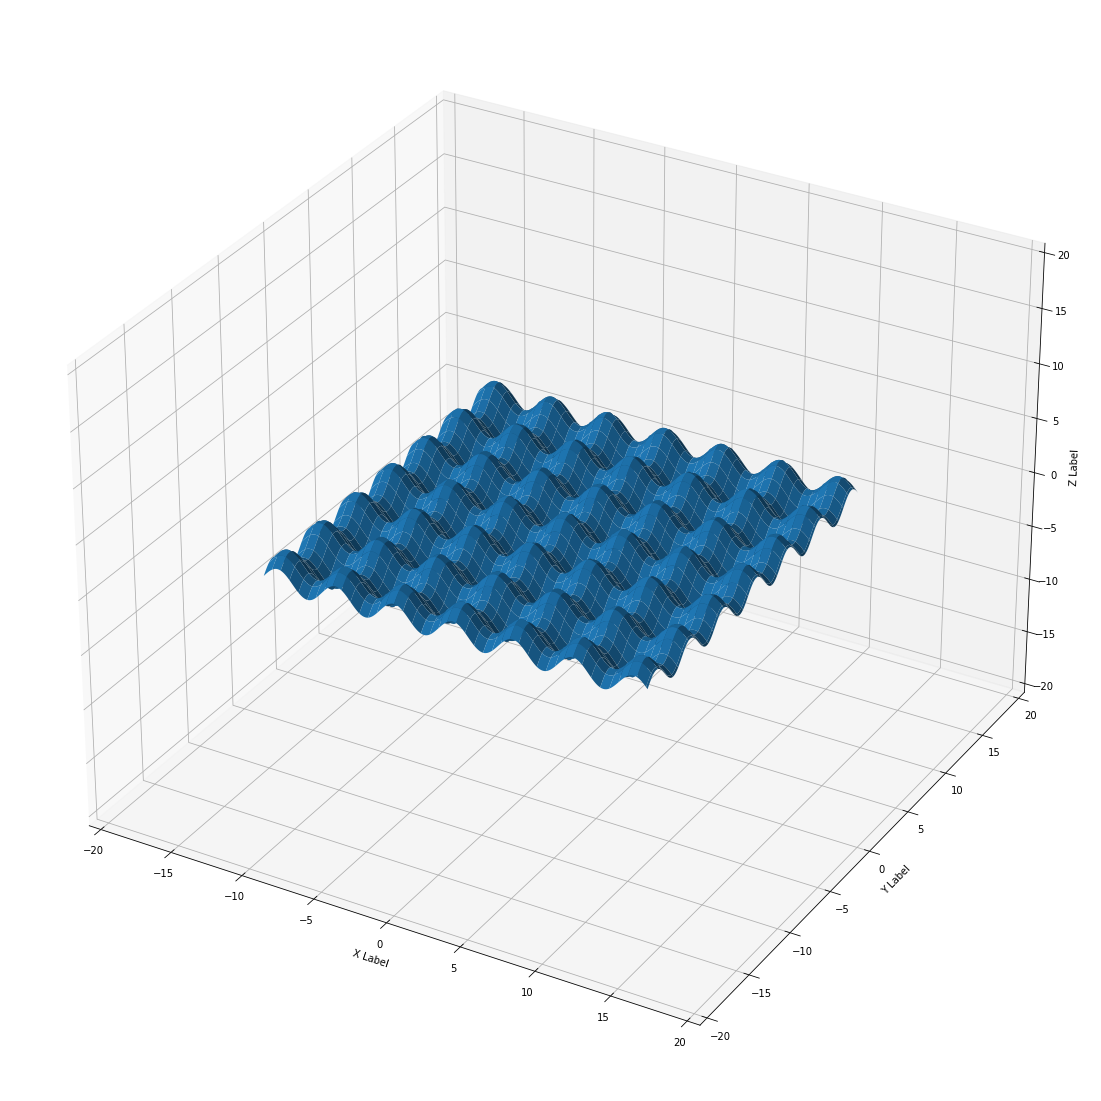

In [7]:
a = 0.5
rang = 20

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
x = np.array(x_train)[:,0]
y = np.array(x_train)[:,1]
X = x.reshape(260,260)
Y = y.reshape(260,260)
Z = np.array(y_train)
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_zlim3d(-rang, rang)
ax.set_ylim3d(-rang, rang)
ax.set_xlim3d(-rang, rang)
plt.savefig('train-dist.pdf')
plt.show()

In [8]:
x_train = torch.tensor(x_train,dtype=torch.float)
y_train = torch.tensor(y_train,dtype=torch.float)
x_test = torch.tensor(x_test,dtype=torch.float)
y_test = torch.tensor(y_test,dtype=torch.float)
y_train = torch.unsqueeze(y_train, -1)
y_test = torch.unsqueeze(y_test, -1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([67600, 2]) torch.Size([67600, 1]) torch.Size([92400, 2]) torch.Size([92400, 1])


<ipython-input-8-929e7ba5557e>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  x_train = torch.tensor(x_train,dtype=torch.float)


In [9]:
def visualize(net, epoch, run):
    net.eval()
    a = 0.5
    rang = 40

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-rang, rang, 0.1)
    X, Y = np.meshgrid(x, y)

    tt = torch.tensor([[x,y]for x,y in zip(np.ravel(X), np.ravel(Y))], dtype=torch.float)
    sett = CustomImageDataset(tt,tt)
    dataloader = DataLoader(sett, batch_size=batch_size, shuffle=False)
    zs = torch.tensor([])
    for x,_ in dataloader:
        x = x.to(device)
        pred = net(x)
        pred = pred.cpu().detach()
        zs = torch.cat((zs, pred), dim=0)
#     tt = tt.to(device)
#     zs = net(tt)

    Z = zs.cpu().detach().numpy()
    Z = Z.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax.set_zlim3d(-rang, rang)
    ax.set_ylim3d(-rang, rang)
    ax.set_xlim3d(-rang, rang)

    fname = '../pdlt-theories/plots-4/run4-{}.pdf'.format(epoch+run)
    plt.savefig(fname)
    plt.show()

In [10]:
#x = torch.tensor([[x,y]for x,y in zip(np.ravel(X), np.ravel(Y))], dtype=torch.float)

In [11]:
def train(net, train_iter, test_iter, loss, num_epochs, updater, vis, run):
    metrics = {'train_losses': [],
               'test_losses': []}
    net.to(device)
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater)
        test_loss = evaluate_loss(net, test_iter, loss)
        metrics['train_losses'].append(train_loss)
        metrics['test_losses'].append(test_loss)
        torch.cuda.empty_cache()
        if epoch % vis == 0:
            print('{} : train_loss = {}'.format(epoch, train_loss))
            print('{} : test_loss = {}'.format(epoch, test_loss))
            print('------------')
            visualize(net, epoch, run)
            torch.cuda.empty_cache()
    return metrics

  
def train_epoch(net, train_iter, loss, updater):
    net.train()
    metric_l = 0
    n = 0
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        updater.step()
        with torch.no_grad():
            metric_l += l*len(y)
            n += y.numel()
    return metric_l / n

def evaluate_loss(net, data_iter, loss):
    metric_l = 0
    n = 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        out = net(X)
        l = loss(out, y)
        with torch.no_grad():
            metric_l += l*len(y)
            n += y.numel()
    return metric_l / n

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):        
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

In [20]:
blks = []
n = 512
L = 44
for _ in range(L-2):
    blks.append( nn.Sequential(nn.Linear(n, n), nn.ReLU()))

In [21]:
inp = nn.Sequential(nn.Linear(2, n), nn.ReLU())
mid = nn.Sequential(*blks)
top = nn.Sequential(nn.Linear(n, 1))
net = nn.Sequential(inp, mid, top)

#net = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

net.apply(init_weights)
net.to(device)
print()

In [22]:
def count_para(net):
    return sum([p.numel() for p in net.parameters() if p.requires_grad])
count_para(net)

11033601

0 : train_loss = 0.32392624020576477
0 : test_loss = 2.3442509174346924
------------


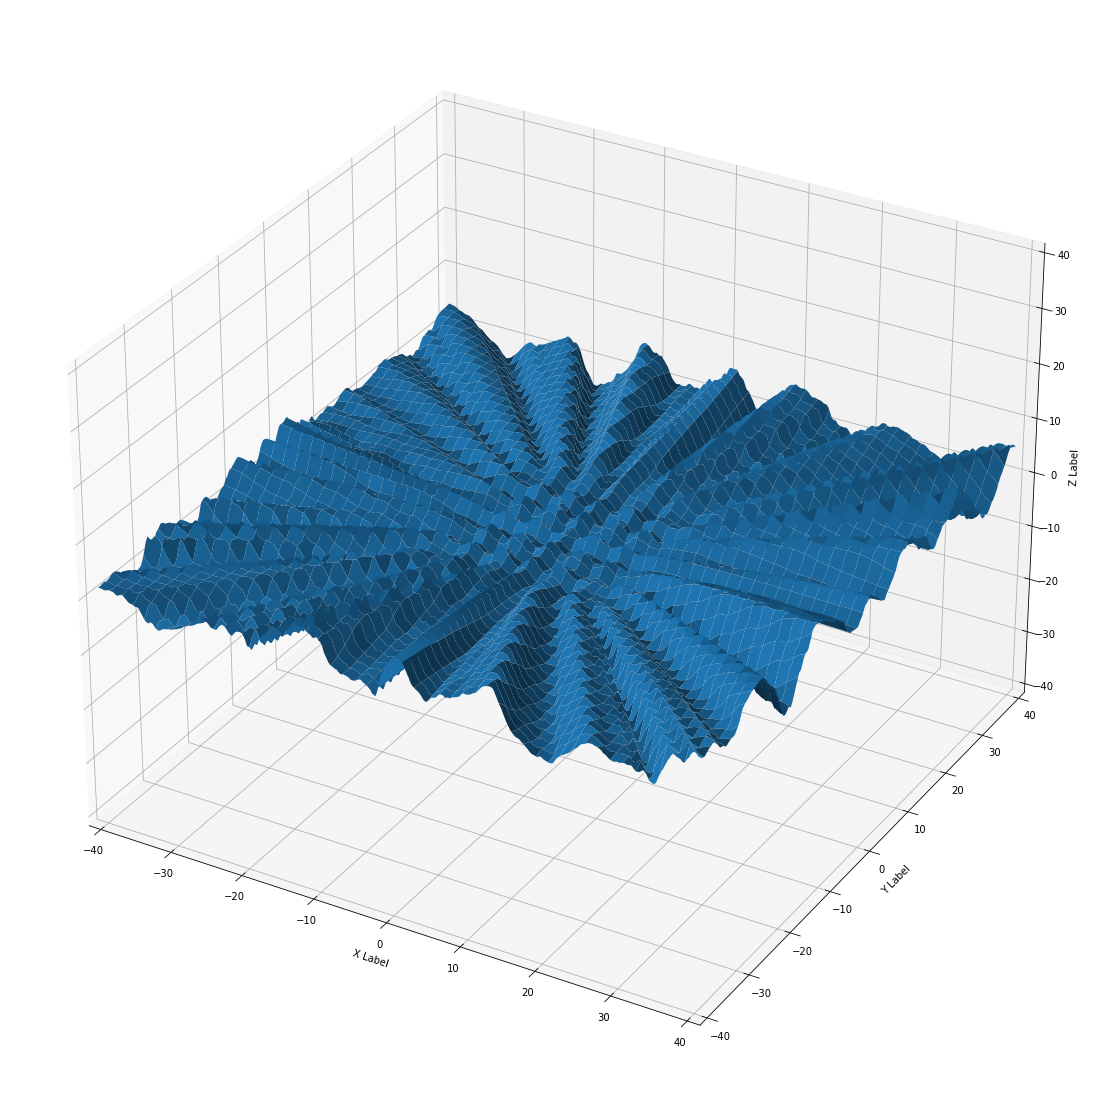

500 : train_loss = 0.23924165964126587
500 : test_loss = 3.118041753768921
------------


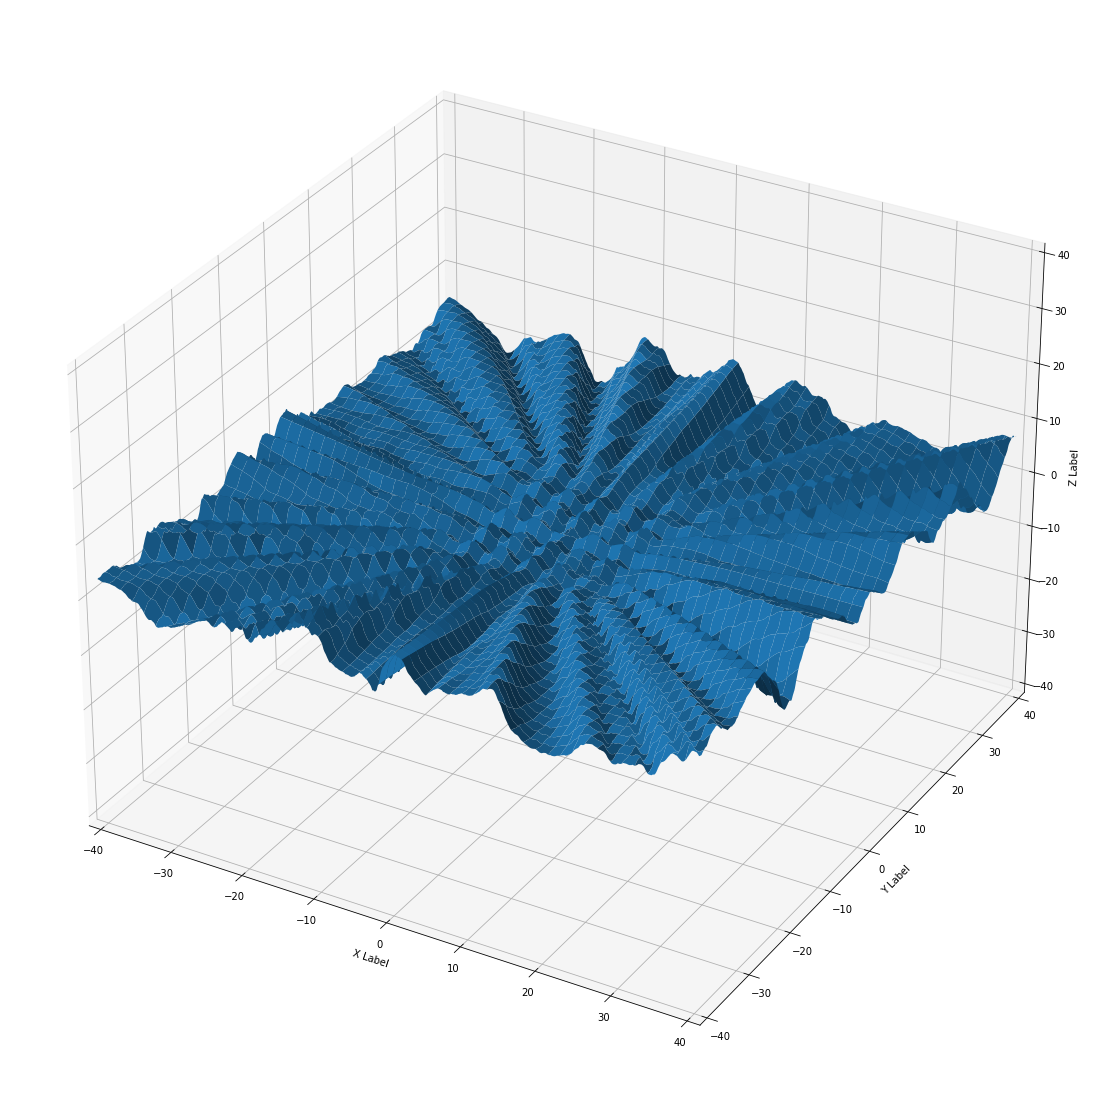

1000 : train_loss = 0.22875827550888062
1000 : test_loss = 3.5355687141418457
------------


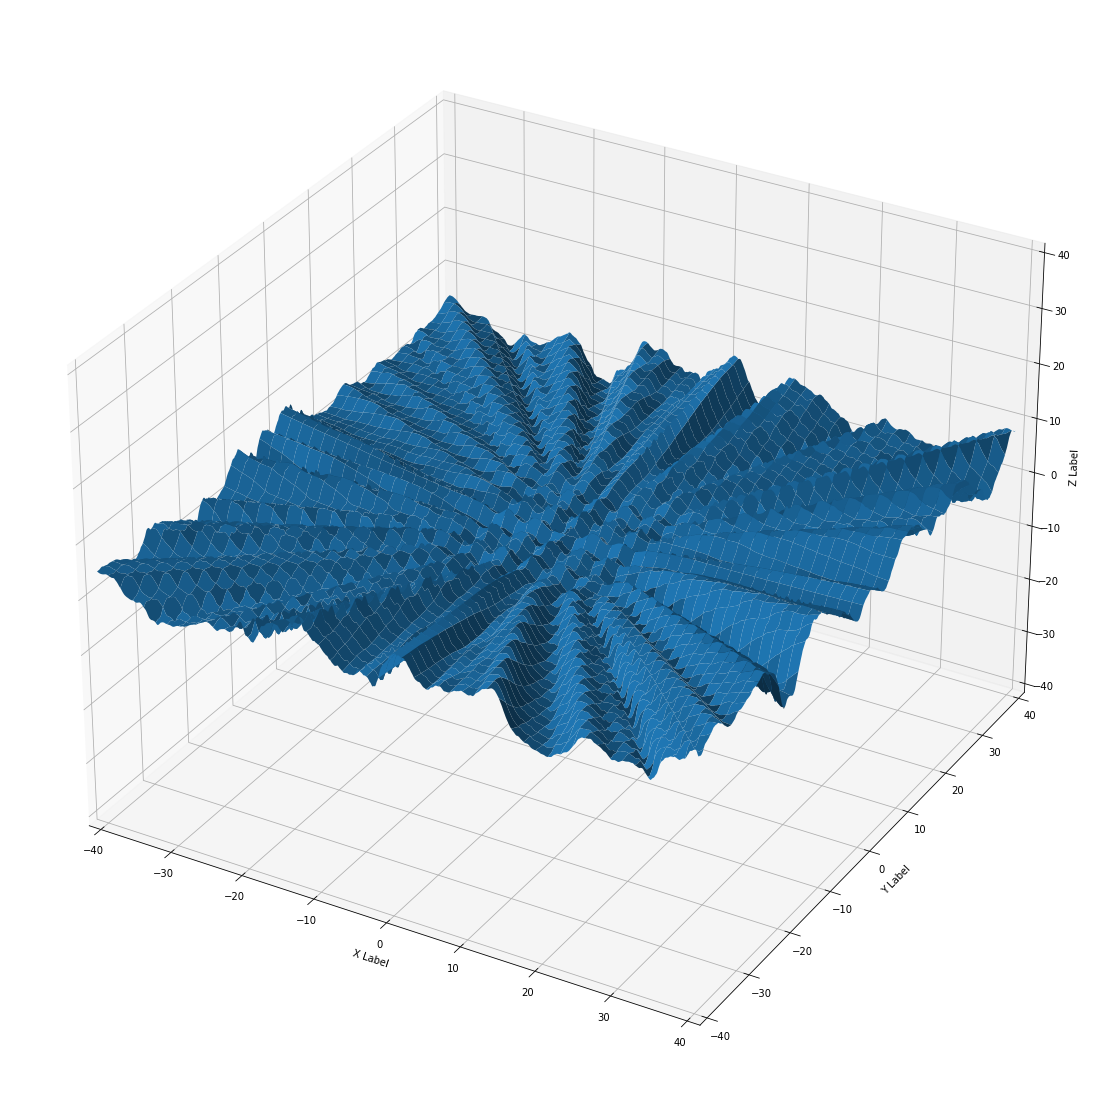

1500 : train_loss = 0.2651383876800537
1500 : test_loss = 4.606205463409424
------------


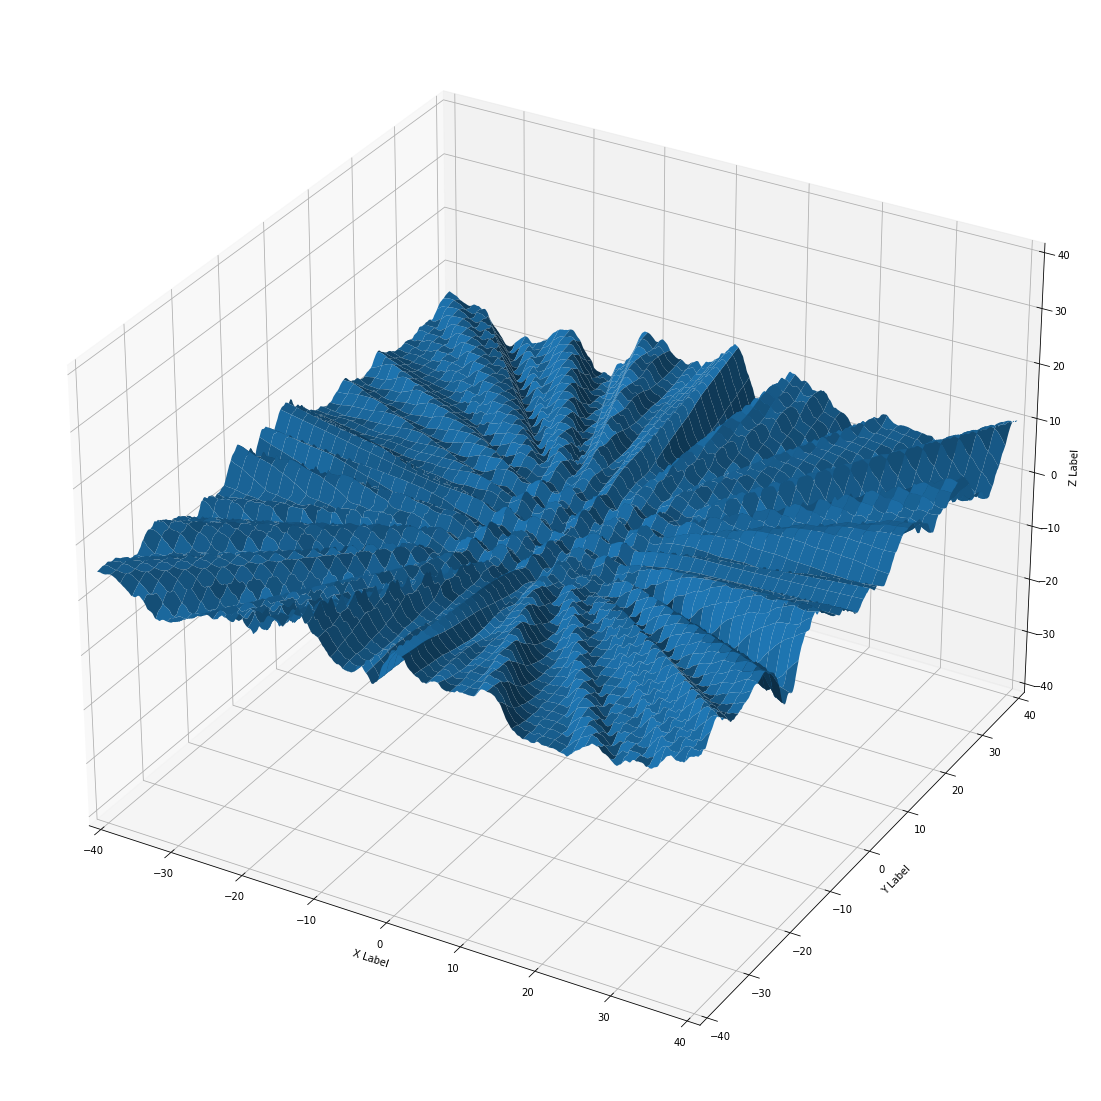

In [23]:
#batch_size, lr, num_epochs = 70000, 0.00001, 100
batch_size, lr, num_epochs = 7000, 0.00001, 2000
vis = 500
run = 5000
loss = nn.MSELoss() #reduction='mean'
trainer = torch.optim.SGD(net.parameters(), lr=lr)

# checkpoint = torch.load('model-44-512-run4.pt')
# net.load_state_dict(checkpoint['model_state_dict'])
# trainer.load_state_dict(checkpoint['optimizer_state_dict'])

#visualize(net,-1, run)

trainset = CustomImageDataset(x_train,y_train)
testset = CustomImageDataset(x_test,y_test)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
metrics = train(net, train_dataloader, test_dataloader, loss, num_epochs, trainer, vis, run)

0 : train_loss = 0.6050339937210083
0 : test_loss = 2.988227367401123
------------


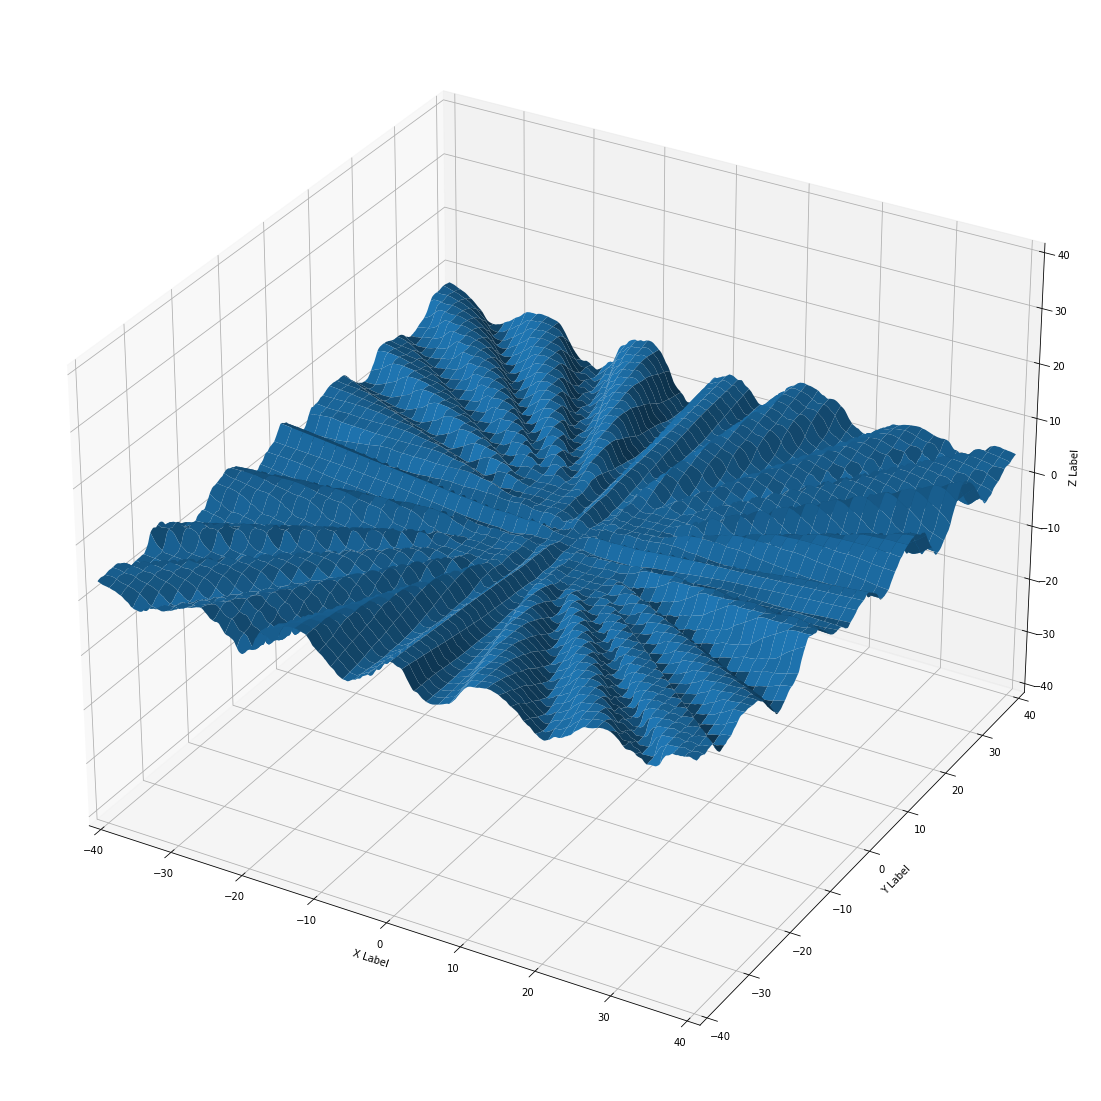

500 : train_loss = 0.534773588180542
500 : test_loss = 3.667227029800415
------------


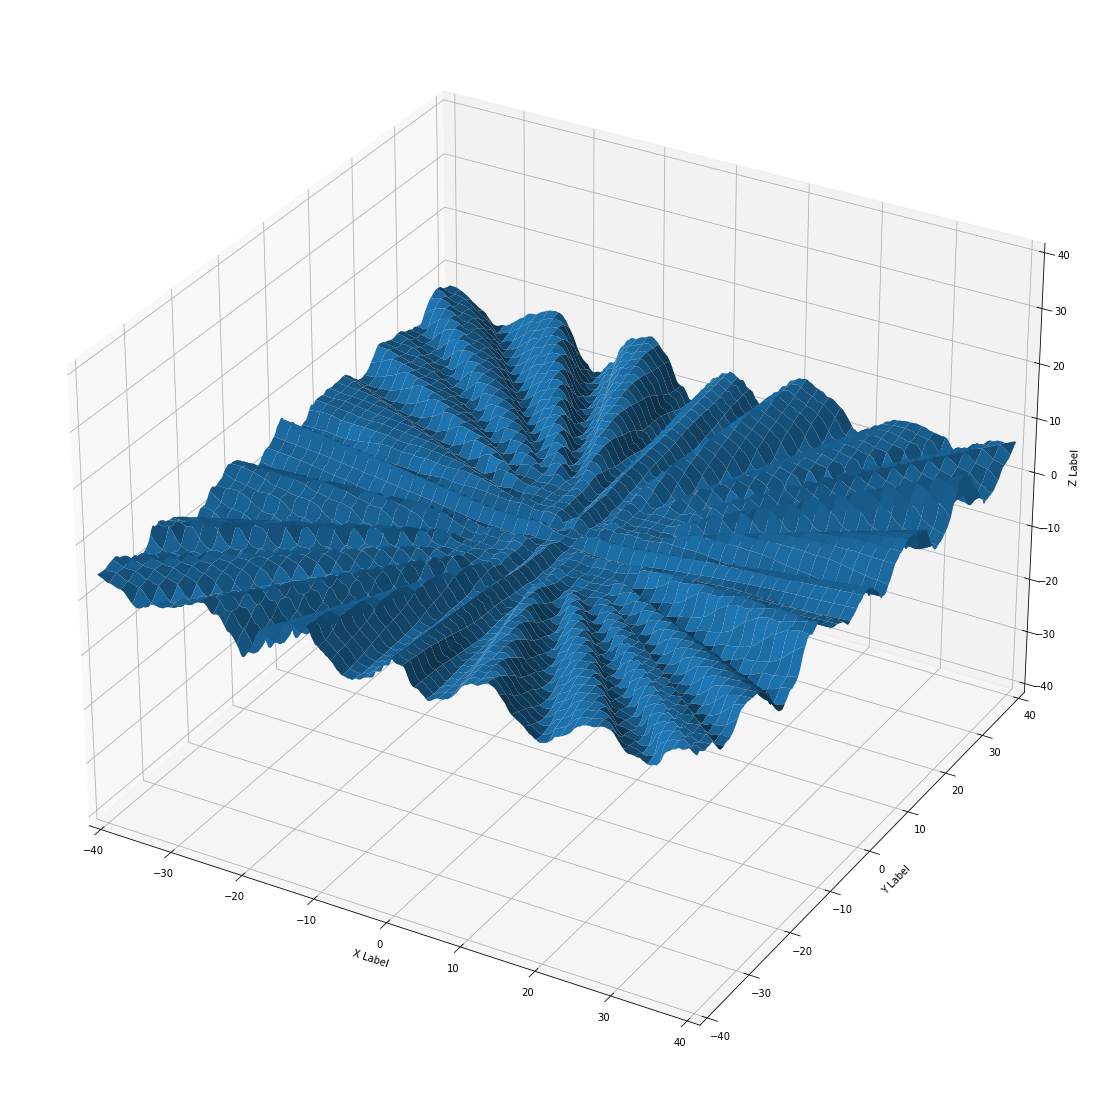

1000 : train_loss = 0.4517471194267273
1000 : test_loss = 3.8366336822509766
------------


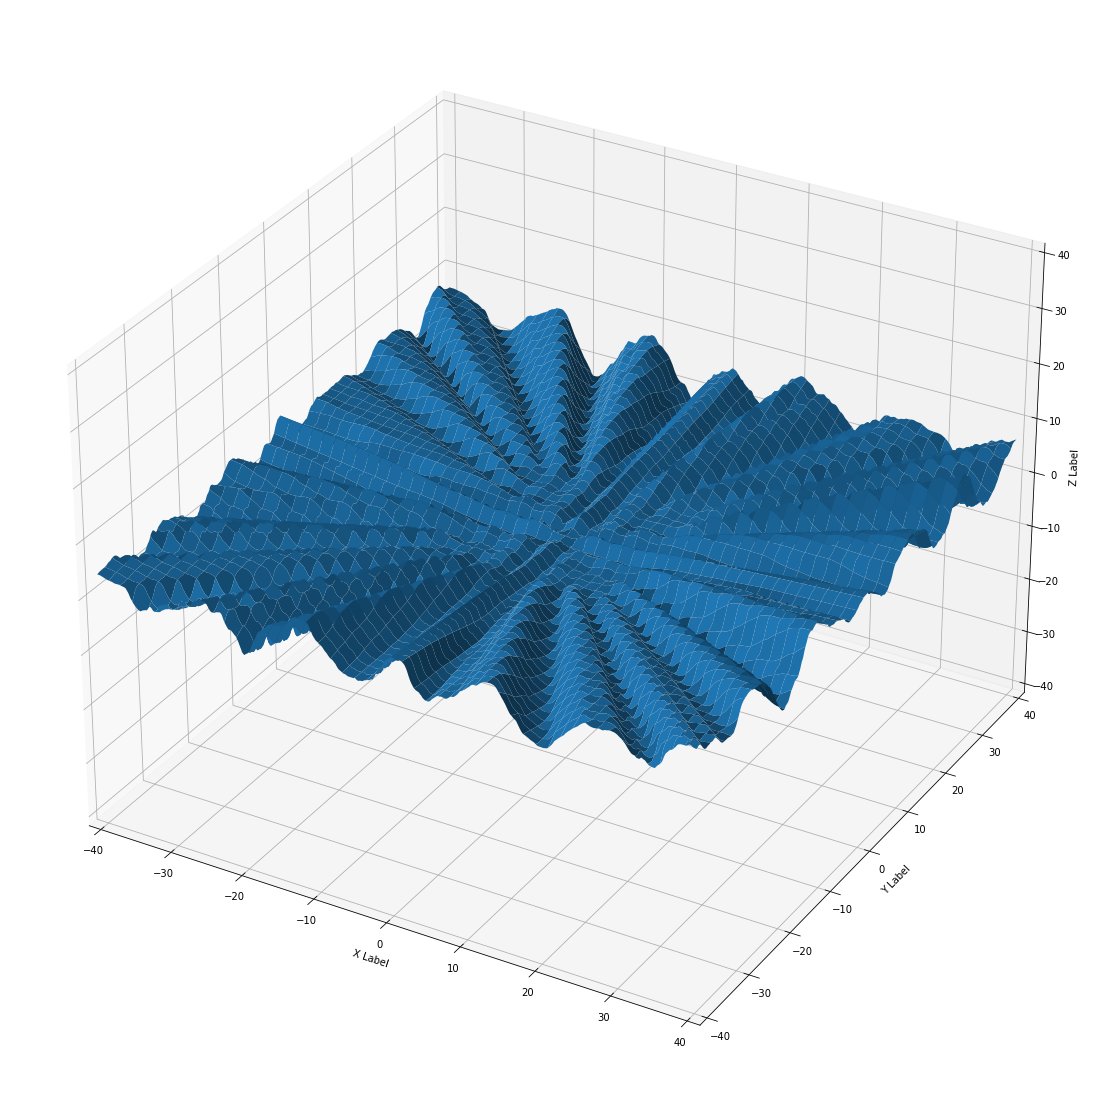

1500 : train_loss = 0.4052732288837433
1500 : test_loss = 3.659614324569702
------------


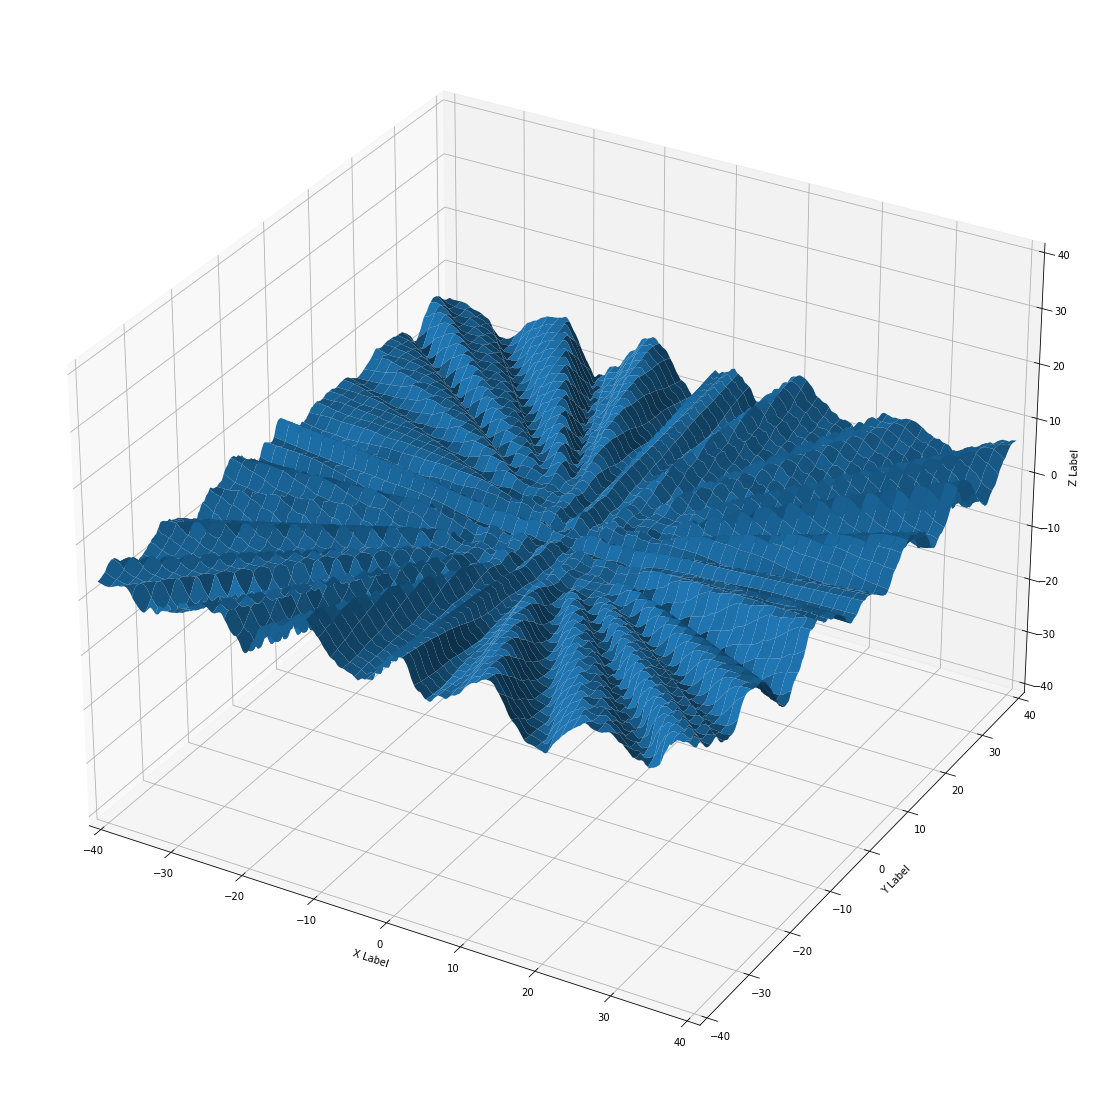

In [17]:
batch_size, lr, num_epochs = 7000, 0.00001, 2000
vis = 500
run = 1000
loss = nn.MSELoss() #reduction='mean'
trainer = torch.optim.SGD(net.parameters(), lr=lr) 

trainset = CustomImageDataset(x_train,y_train)
testset = CustomImageDataset(x_test,y_test)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
metrics = train(net, train_dataloader, test_dataloader, loss, num_epochs, trainer, vis, run)

0 : train_loss = 0.3643033802509308
0 : test_loss = 2.840895175933838
------------


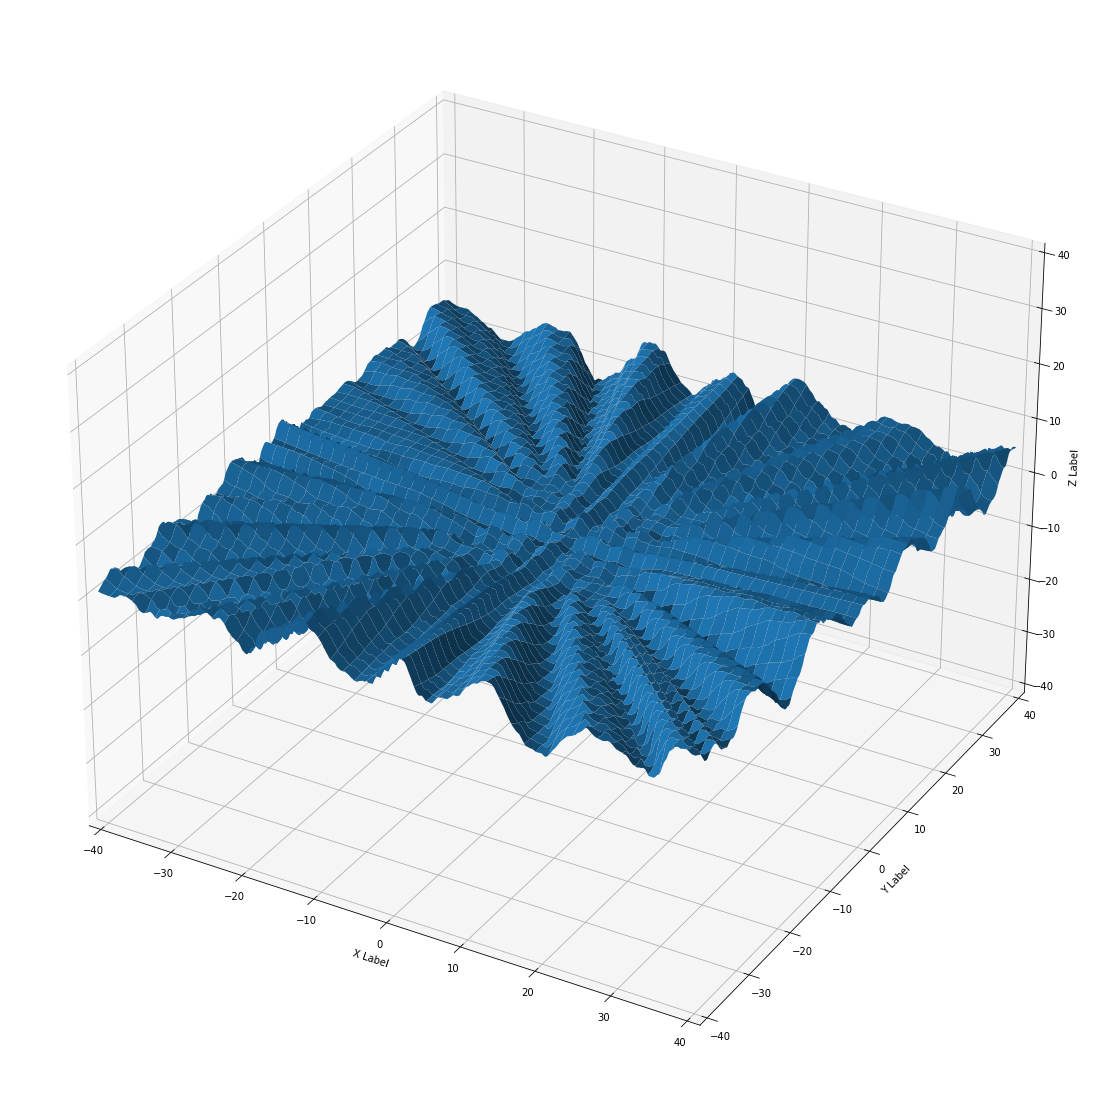

500 : train_loss = 0.35582593083381653
500 : test_loss = 3.9429450035095215
------------


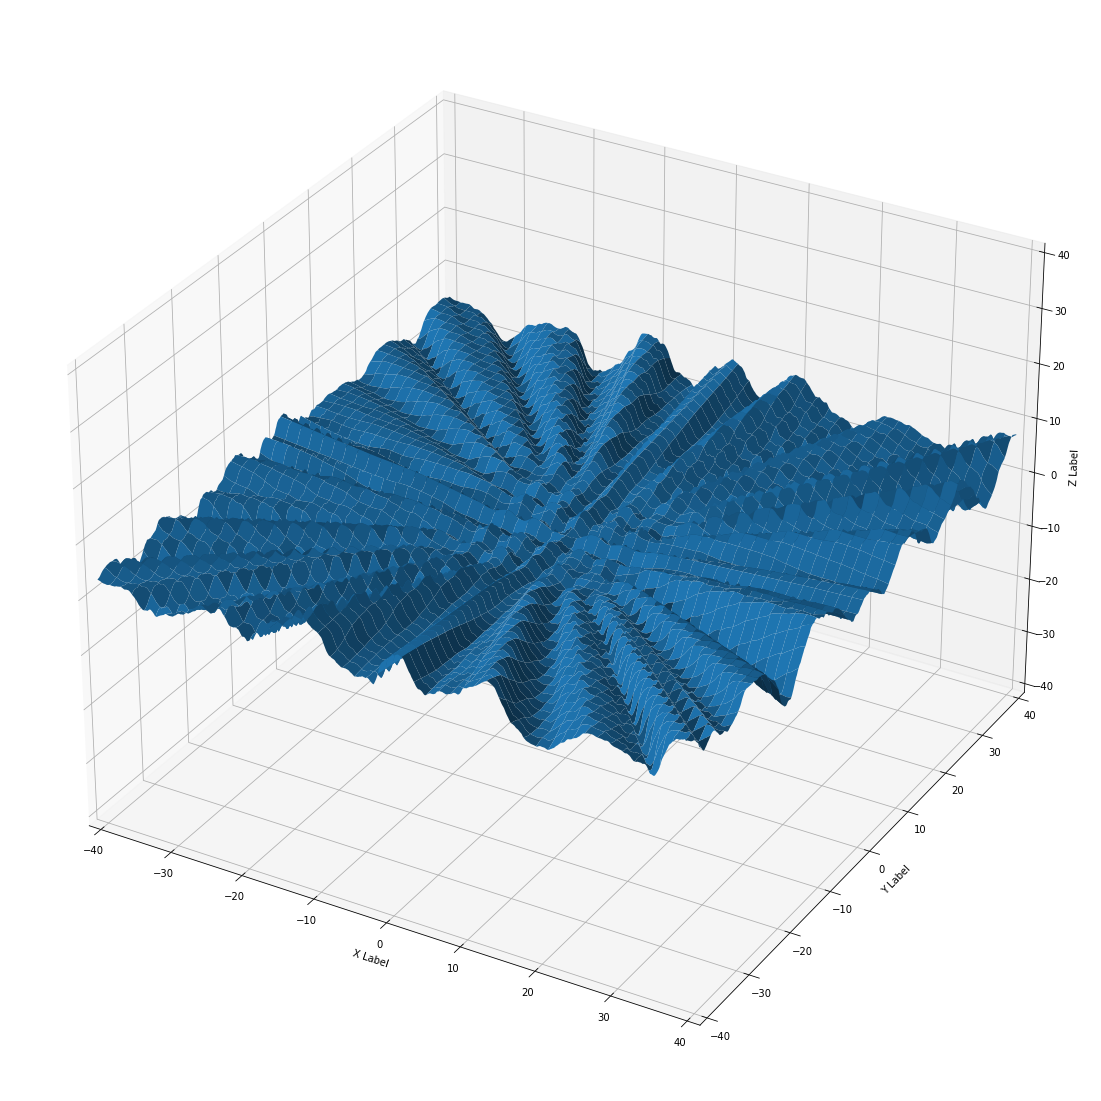

1000 : train_loss = 0.2786500155925751
1000 : test_loss = 3.4862430095672607
------------


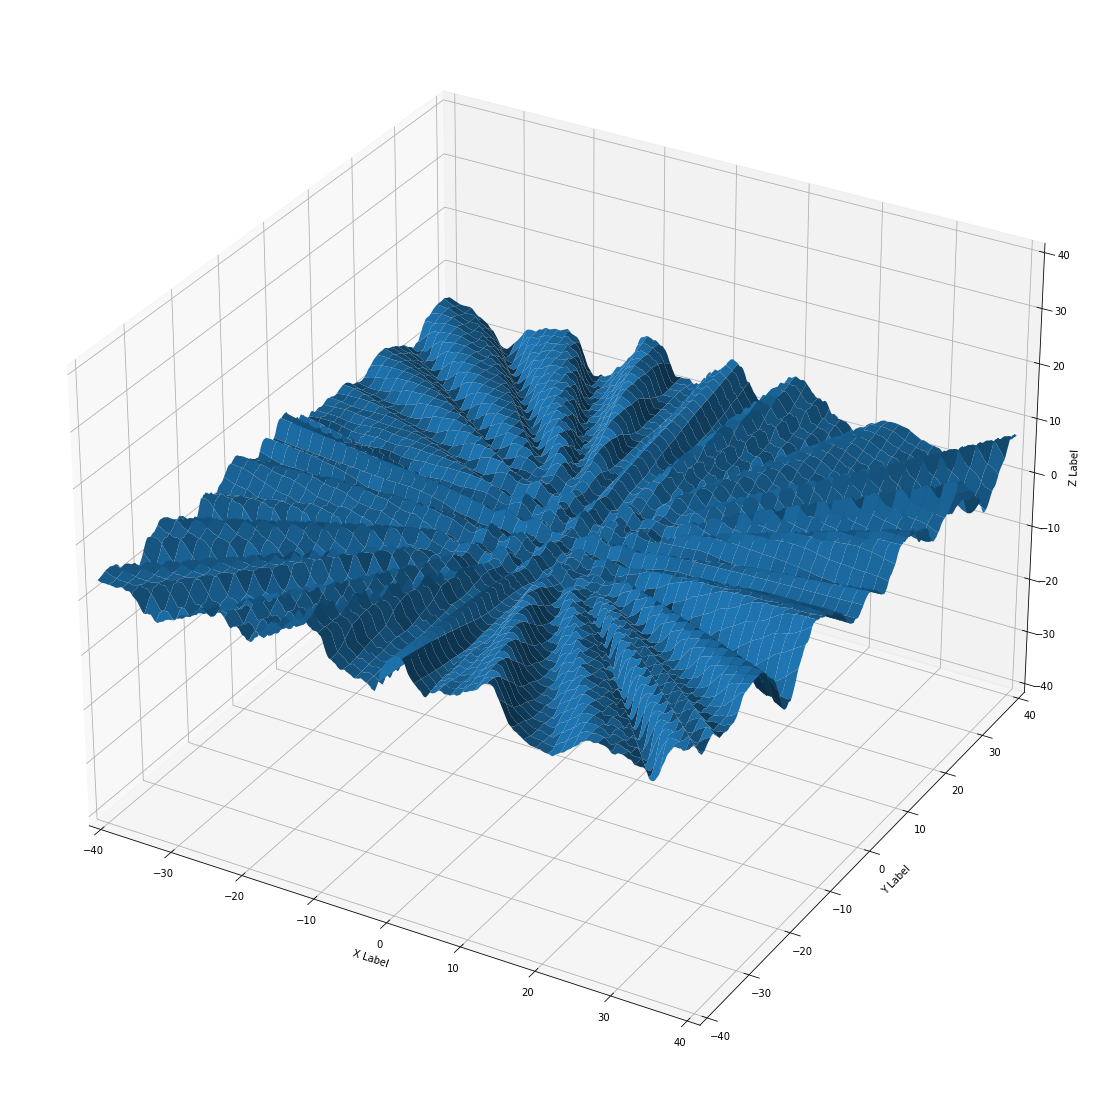

1500 : train_loss = 0.27790313959121704
1500 : test_loss = 3.9678730964660645
------------


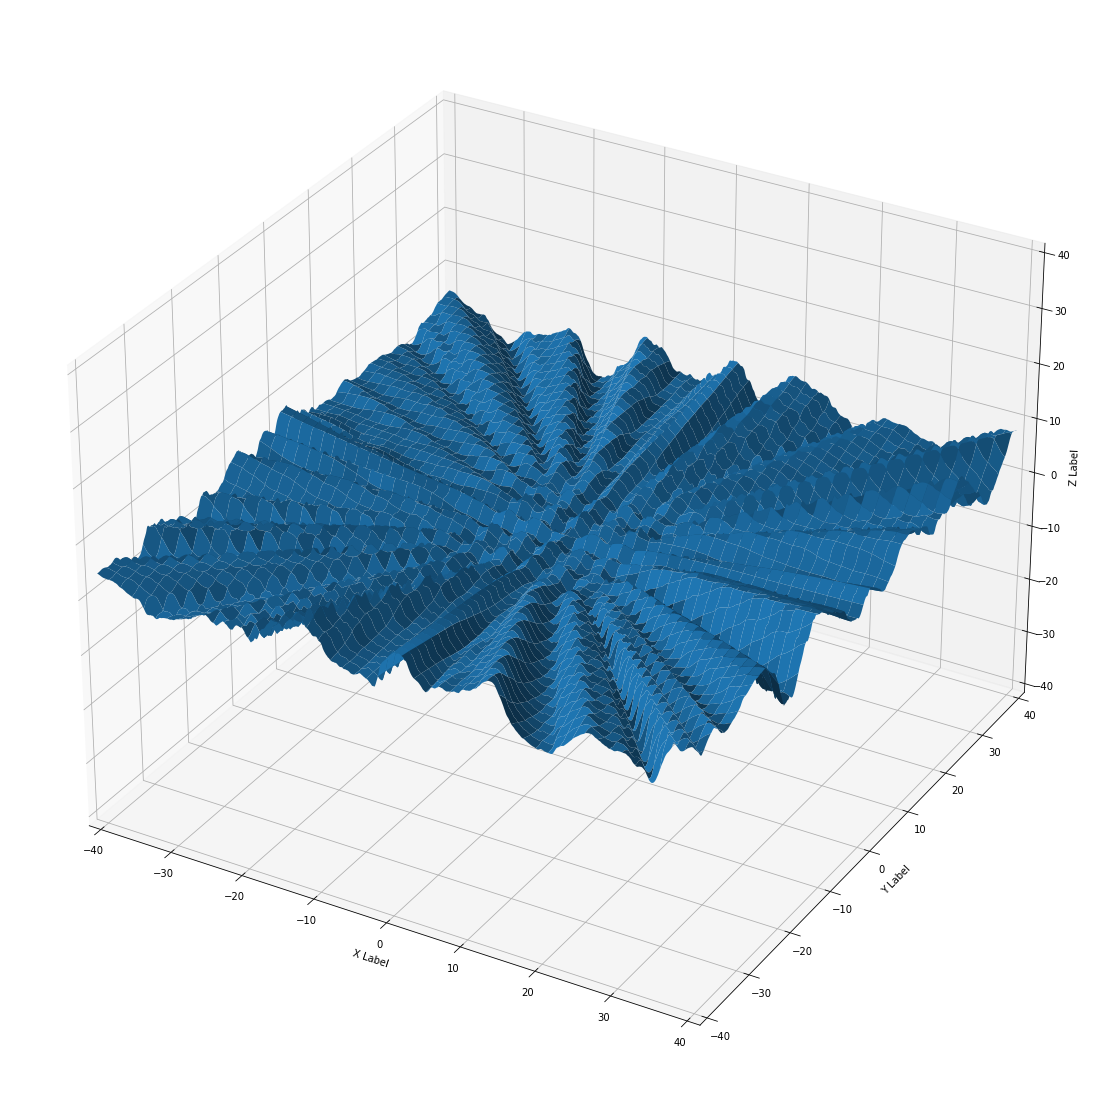

KeyboardInterrupt: 

In [18]:
batch_size, lr, num_epochs = 7000, 0.00001, 2000
vis = 500
run = 3000
loss = nn.MSELoss() #reduction='mean'
trainer = torch.optim.SGD(net.parameters(), lr=lr) 

trainset = CustomImageDataset(x_train,y_train)
testset = CustomImageDataset(x_test,y_test)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
metrics = train(net, train_dataloader, test_dataloader, loss, num_epochs, trainer, vis, run)

In [25]:
EPOCH = 7000
PATH = "model-44-512-run4-2.pt"
LOSS = loss

torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': trainer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [22]:
len(metrics['test_losses']) #[-1], metrics['train_losses'][-1]

2000

In [ ]:
a = 0.5
rang = 40

def fun(x, y):
    return math.cos(a*math.pi*x) +  math.cos(a*math.pi*y)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-rang, rang, 0.1)
X, Y = np.meshgrid(x, y)

tt = torch.tensor([[x,y]for x,y in zip(np.ravel(X), np.ravel(Y))], dtype=torch.float)
tt = tt.to(device)
zs = net(tt)

Z = zs.cpu().detach().numpy()
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_zlim3d(-rang, rang)
ax.set_ylim3d(-rang, rang)
ax.set_xlim3d(-rang, rang)

plt.show()